### Clustering of bid requests time-series with Dynamic Time Warping as a measure of similarity

In [ ]:
%matplotlib inline
import os
import glob
import warnings
import fastparquet as fp
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

from os.path import join, normpath
from pandasql import sqldf


warnings.filterwarnings("ignore")
pd.options.display.max_columns = None


In [2]:
"""
    Distance estimation
"""
def LB_Keogh(s1, s2, r):
    LB_sum=0
    for ind,i in enumerate(s1):
        
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return np.sqrt(LB_sum)

In [3]:
"""
    Dynamic Time Warping similarity
"""

def DTWDistance(s1, s2):
    DTW={}
    
    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

In [4]:
"""
    Dynamic Time Warping similarity with window
"""
def DTWDistanceWithWindow(s1, s2, w):
    DTW={}
    
    w = max(w, abs(len(s1)-len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])


In [5]:
"""
    Set dirs
"""
cwd = os.getcwd()
data_dir = join(cwd, 'data')
# parquet_dir = join(data_dir, os.listdir(data_dir).pop())
parquet_dir = '/Users/kip/PycharmProjects/geofraud/data/bid-summary-sample-week-stratified-agg'
parquet_dir


'/Users/kip/PycharmProjects/geofraud/data/bid-summary-sample-week-stratified-agg'

In [6]:
"""
    Read parquet files into a df
"""

files = glob.glob(parquet_dir + '/*.parquet')
pf = fp.ParquetFile(files)
data = pf.to_pandas()
data.head()

,utc_datetime,device_id,bids
0,2018-05-11 02:00:00,533633a0-e88c-44c2-bf1a-7bb2a583b65e,3.0
1,2018-05-11 02:00:00,f7314617-2410-43ce-b6da-6e728bb88208,3.0
2,2018-05-11 02:00:00,700f1198-c5c3-4489-bd3f-62e7e9c7fb1b,2.0
3,2018-05-11 02:00:00,bf801fba-a01f-4382-9b1e-975e54f99216,3.0
4,2018-05-11 02:00:00,84bc4c98-fe01-4fda-8898-e98eb9fc6fd3,2.0


In [7]:
"""
    Create a device vs. datetime matrix with number of bids
"""

df_ts = data.pivot(index='device_id', columns='utc_datetime')[['bids']].fillna(0.0)
df_ts.columns = df_ts.columns.get_level_values(1)
df_ts.head()

utc_datetime,2018-05-05 05:00:00,2018-05-05 06:00:00,2018-05-05 07:00:00,2018-05-05 08:00:00,2018-05-05 09:00:00,2018-05-05 10:00:00,2018-05-05 11:00:00,2018-05-05 12:00:00,2018-05-05 13:00:00,2018-05-05 14:00:00,2018-05-05 15:00:00,2018-05-05 16:00:00,2018-05-05 17:00:00,2018-05-05 18:00:00,2018-05-05 19:00:00,2018-05-05 20:00:00,2018-05-05 21:00:00,2018-05-05 22:00:00,2018-05-05 23:00:00,2018-05-06 00:00:00,2018-05-06 01:00:00,2018-05-06 02:00:00,2018-05-06 03:00:00,2018-05-06 04:00:00,2018-05-06 05:00:00,2018-05-06 06:00:00,2018-05-06 07:00:00,2018-05-06 08:00:00,2018-05-06 09:00:00,2018-05-06 10:00:00,2018-05-06 11:00:00,2018-05-06 12:00:00,2018-05-06 13:00:00,2018-05-06 14:00:00,2018-05-06 15:00:00,2018-05-06 16:00:00,2018-05-06 17:00:00,2018-05-06 18:00:00,2018-05-06 19:00:00,2018-05-06 20:00:00,2018-05-06 21:00:00,2018-05-06 22:00:00,2018-05-06 23:00:00,2018-05-07 00:00:00,2018-05-07 01:00:00,2018-05-07 02:00:00,2018-05-07 03:00:00,2018-05-07 04:00:00,2018-05-07 05:00:00,2018-05-07 06:00:00,2018-05-07 07:00:00,2018-05-07 08:00:00,2018-05-07 09:00:00,2018-05-07 10:00:00,2018-05-07 11:00:00,2018-05-07 12:00:00,2018-05-07 13:00:00,2018-05-07 14:00:00,2018-05-07 15:00:00,2018-05-07 16:00:00,2018-05-07 17:00:00,2018-05-07 18:00:00,2018-05-07 19:00:00,2018-05-07 20:00:00,2018-05-07 21:00:00,2018-05-07 22:00:00,2018-05-07 23:00:00,2018-05-08 00:00:00,2018-05-08 01:00:00,2018-05-08 02:00:00,2018-05-08 03:00:00,2018-05-08 04:00:00,2018-05-08 05:00:00,2018-05-08 06:00:00,2018-05-08 07:00:00,2018-05-08 08:00:00,2018-05-08 09:00:00,2018-05-08 10:00:00,2018-05-08 11:00:00,2018-05-08 12:00:00,2018-05-08 13:00:00,2018-05-08 14:00:00,2018-05-08 15:00:00,2018-05-08 16:00:00,2018-05-08 17:00:00,2018-05-08 18:00:00,2018-05-08 19:00:00,2018-05-08 20:00:00,2018-05-08 21:00:00,2018-05-08 22:00:00,2018-05-08 23:00:00,2018-05-09 00:00:00,2018-05-09 01:00:00,2018-05-09 02:00:00,2018-05-09 03:00:00,2018-05-09 04:00:00,2018-05-09 05:00:00,2018-05-09 06:00:00,2018-05-09 07:00:00,2018-05-09 08:00:00,2018-05-09 09:00:00,2018-05-09 10:00:00,2018-05-09 11:00:00,2018-05-09 12:00:00,2018-05-09 13:00:00,2018-05-09 14:00:00,2018-05-09 15:00:00,2018-05-09 16:00:00,2018-05-09 17:00:00,2018-05-09 18:00:00,2018-05-09 19:00:00,2018-05-09 20:00:00,2018-05-09 21:00:00,2018-05-09 22:00:00,2018-05-09 23:00:00,2018-05-10 00:00:00,2018-05-10 01:00:00,2018-05-10 02:00:00,2018-05-10 03:00:00,2018-05-10 04:00:00,2018-05-10 05:00:00,2018-05-10 06:00:00,2018-05-10 07:00:00,2018-05-10 08:00:00,2018-05-10 09:00:00,2018-05-10 10:00:00,2018-05-10 11:00:00,2018-05-10 12:00:00,2018-05-10 13:00:00,2018-05-10 14:00:00,2018-05-10 15:00:00,2018-05-10 16:00:00,2018-05-10 17:00:00,2018-05-10 18:00:00,2018-05-10 19:00:00,2018-05-10 20:00:00,2018-05-10 21:00:00,2018-05-10 22:00:00,2018-05-10 23:00:00,2018-05-11 00:00:00,2018-05-11 01:00:00,2018-05-11 02:00:00,2018-05-11 03:00:00,2018-05-11 04:00:00,2018-05-11 05:00:00,2018-05-11 06:00:00,2018-05-11 07:00:00,2018-05-11 08:00:00,2018-05-11 09:00:00,2018-05-11 10:00:00,2018-05-11 11:00:00,2018-05-11 12:00:00,2018-05-11 13:00:00,2018-05-11 14:00:00,2018-05-11 15:00:00,2018-05-11 16:00:00,2018-05-11 17:00:00,2018-05-11 18:00:00,2018-05-11 19:00:00,2018-05-11 20:00:00,2018-05-11 21:00:00,2018-05-11 22:00:00,2018-05-11 23:00:00,2018-05-12 00:00:00,2018-05-12 01:00:00,2018-05-12 02:00:00,2018-05-14 00:00:00,2018-05-14 01:00:00,2018-05-14 02:00:00,2018-05-14 03:00:00
device_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000320b-d2de-4b0c-b0f5-6e4851bdf364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [8]:
sums = df_ts.apply(lambda x: np.sum(x), axis=1).to_frame(name='weekly_bids')
sums.head()

,weekly_bids
device_id,
0000320b-d2de-4b0c-b0f5-6e4851bdf364,3.0
00006c0b-8fd4-48d9-825e-5e81342b29c7,8.0
00007acd-499c-4fc6-b40a-b573e4663496,3.0
00008bd3-668b-4a31-8e81-fabb3ba1b2c3,11.0
0000d692-eda6-4960-91ed-b20887efe033,212.0


In [9]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler(with_mean=True, with_std=True)
sums['log_weekly_bids'] = np.log(sums.weekly_bids)
sums['log_weekly_bids_std'] = scaler.fit_transform(sums.log_weekly_bids.values.reshape(-1, 1))

sums.head()

,weekly_bids,log_weekly_bids,log_weekly_bids_std
device_id,,,
0000320b-d2de-4b0c-b0f5-6e4851bdf364,3.0,1.098612,-1.098742
00006c0b-8fd4-48d9-825e-5e81342b29c7,8.0,2.079442,-0.524371
00007acd-499c-4fc6-b40a-b573e4663496,3.0,1.098612,-1.098742
00008bd3-668b-4a31-8e81-fabb3ba1b2c3,11.0,2.397895,-0.337885
0000d692-eda6-4960-91ed-b20887efe033,212.0,5.356586,1.394715


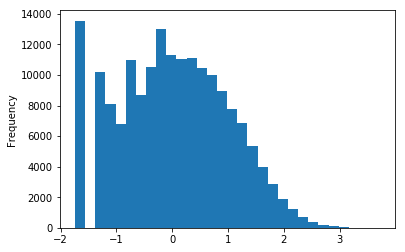

In [10]:
sums.log_weekly_bids_std.plot(kind='hist', bins=30)

In [13]:
from itertools import combinations, permutations


sdt = 2.5
window_size = 3
dtws = pd.DataFrame([
    [x[0], x[1], LB_Keogh(df_ts[df_ts.index == x[0]].values[0], df_ts[df_ts.index == x[1]].values[0], window_size)]  
    for x in combinations(sums[sums.log_weekly_bids_std >= sdt].index, 2)
], columns=['device01', 'device02', 'dtw_lb'])

In [14]:
import re


columns = ['device01', 'device02', 'dtw_lb']
dtws.loc[:, ['dtw_lb']] = dtws.loc[:, ['dtw_lb']].apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))
dtws.loc[:, columns].sort_values(['dtw_lb'], ascending=[1])

,device01,device02,dtw_lb
91512,54a3581b-35b4-4a54-b48e-79ac1c9272ec,69b60851-ffb2-461c-bd37-4d5dcc54962a,0.000000
144295,aca4c08b-1516-4b96-83b5-a46a2e1a78ee,daed6d1a-af33-48df-9ce8-8b5c37a766d6,0.000000
155909,d35484ac-7834-488d-84c0-e2282631f26c,f93e9cc8-0a93-405c-982f-e9914fadb225,0.000400
106352,69b60851-ffb2-461c-bd37-4d5dcc54962a,7a714acd-16c6-4c09-b6e9-27a9bf2c3959,0.000400
157507,dc56c64d-1032-4465-92d1-421220636a24,df34a7fd-3622-4028-a902-17e18384051d,0.000693
16381,11038e52-2adb-4def-b7a6-16e8cee8a529,9cc943ef-97a9-4fe8-aa0b-003c14390bed,0.000800
16266,11038e52-2adb-4def-b7a6-16e8cee8a529,666247bc-475d-453d-9491-0b4b9ea545c6,0.000800
16241,11038e52-2adb-4def-b7a6-16e8cee8a529,59a10819-a6e0-473e-b464-ee5cd87c14a5,0.001000
9712,07fe248b-1ce8-44ce-a925-cac7664a04ab,5c86d15e-6533-42aa-b2cc-5950845babd8,0.001000
126982,897df1ab-b12e-4658-b81b-4923b8d22731,bc0039f0-021c-4869-a13e-67f55ad541d1,0.001280


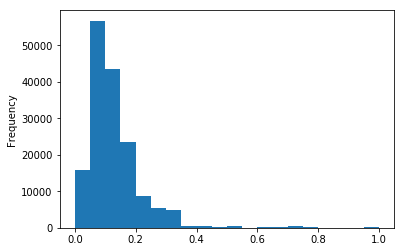

In [15]:
dtws.dtw_lb.plot(kind='hist', bins=20)

Text(0,0.5,'SSE')

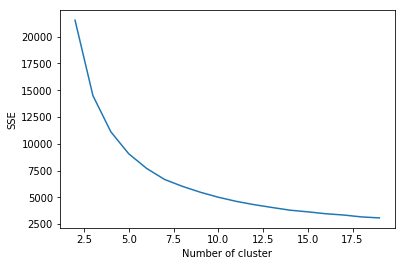

In [44]:
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering


columns = ['device01', 'device02', 'dtw_lb']
train = pd.concat([
    dtws[columns[:2]].apply(lambda x: x.astype('category')),
    dtws[columns[2:]]], axis=1)\
    .pivot(index='device01', columns='device02')[['dtw_lb']].fillna(1.0)
train.columns = train.columns.get_level_values(1)

X = 1.-train.as_matrix()
sse = {}
for k in range(2, 20):
    # cl = KMeans(n_clusters=k, max_iter=1000)
    cl = KMeans(n_clusters=k)
    cl.fit(X)
    c = pd.DataFrame(cl.predict(X).reshape(-1, 1), columns=['cluster'], index=train.index)
    sse[k] = cl.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")


In [45]:
sse

{2: 21525.0489911357,
 3: 14486.293972965548,
 4: 11113.344549723706,
 5: 9063.506981712047,
 6: 7697.093718065353,
 7: 6668.611579599931,
 8: 6023.9468802868,
 9: 5475.515525106896,
 10: 5011.29628913053,
 11: 4626.92549306587,
 12: 4317.681646909719,
 13: 4054.20613429352,
 14: 3803.5430990060663,
 15: 3646.6439819649077,
 16: 3469.9412968142783,
 17: 3350.512094230903,
 18: 3173.500999608667,
 19: 3080.059558904002}

In [46]:
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering

# .apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))
columns = ['device01', 'device02', 'dtw_lb']

train = pd.concat([
    dtws[columns[:2]].apply(lambda x: x.astype('category')),
    dtws[columns[2:]]], axis=1)\
    .pivot(index='device01', columns='device02')[['dtw_lb']].fillna(1.0)
train.columns = train.columns.get_level_values(1)
cl = KMeans(n_clusters=9)

c = pd.DataFrame(cl.fit_predict(1.-train.as_matrix()).reshape(-1, 1), columns=['cluster'], index=train.index)
c.groupby(['cluster']).agg({'cluster': 'count'})

,cluster
cluster,
0,63
1,63
2,56
3,61
4,69
5,65
6,65
7,65
8,61


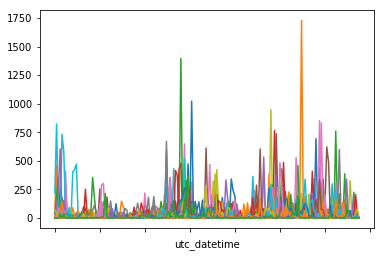

In [47]:
cluster_id = 0
df_ts[df_ts.index.isin(c[c.cluster == cluster_id].index)].T.plot(legend=False)

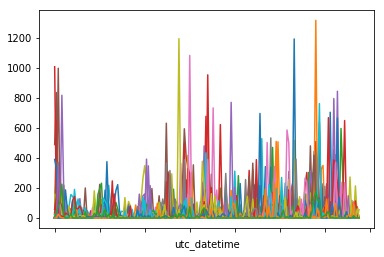

In [48]:
cluster_id = 1
df_ts[df_ts.index.isin(c[c.cluster == cluster_id].index)].T.plot(legend=False)

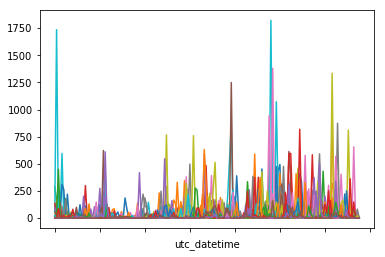

In [49]:
cluster_id = 2
df_ts[df_ts.index.isin(c[c.cluster == cluster_id].index)].T.plot(legend=False)

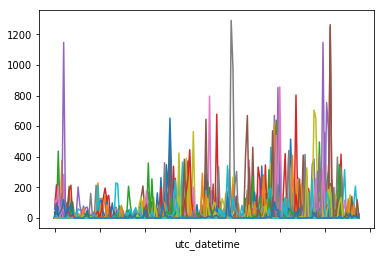

In [50]:
cluster_id = 3
df_ts[df_ts.index.isin(c[c.cluster == cluster_id].index)].T.plot(legend=False)

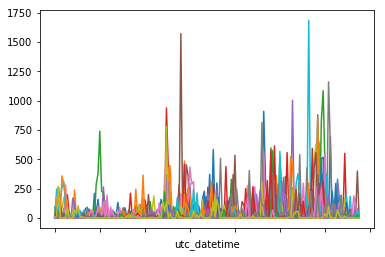

In [51]:
cluster_id = 4
df_ts[df_ts.index.isin(c[c.cluster == cluster_id].index)].T.plot(legend=False)

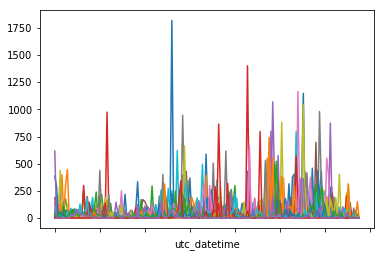

In [52]:
cluster_id = 5
df_ts[df_ts.index.isin(c[c.cluster == cluster_id].index)].T.plot(legend=False)

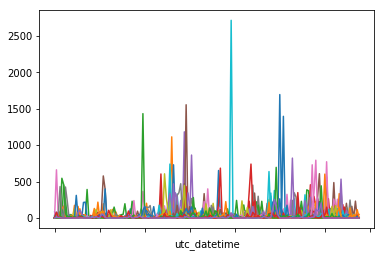

In [53]:
cluster_id = 6
df_ts[df_ts.index.isin(c[c.cluster == cluster_id].index)].T.plot(legend=False)

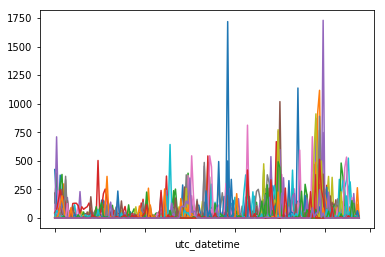

In [54]:
cluster_id = 7
df_ts[df_ts.index.isin(c[c.cluster == cluster_id].index)].T.plot(legend=False)

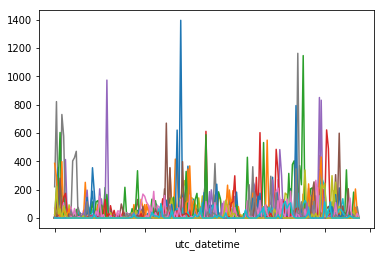

In [41]:
cluster_id = 8
df_ts[df_ts.index.isin(c[c.cluster == cluster_id].index)].T.plot(legend=False)

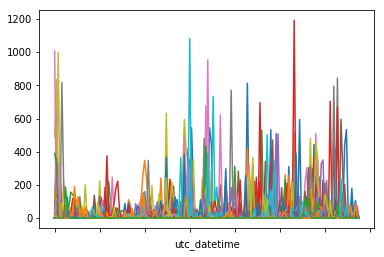

In [42]:
cluster_id = 9
df_ts[df_ts.index.isin(c[c.cluster == cluster_id].index)].T.plot(legend=False)

In [55]:
df_ts[df_ts.index.isin(c[c.cluster == cluster_id].index)]

utc_datetime,2018-05-05 05:00:00,2018-05-05 06:00:00,2018-05-05 07:00:00,2018-05-05 08:00:00,2018-05-05 09:00:00,2018-05-05 10:00:00,2018-05-05 11:00:00,2018-05-05 12:00:00,2018-05-05 13:00:00,2018-05-05 14:00:00,2018-05-05 15:00:00,2018-05-05 16:00:00,2018-05-05 17:00:00,2018-05-05 18:00:00,2018-05-05 19:00:00,2018-05-05 20:00:00,2018-05-05 21:00:00,2018-05-05 22:00:00,2018-05-05 23:00:00,2018-05-06 00:00:00,2018-05-06 01:00:00,2018-05-06 02:00:00,2018-05-06 03:00:00,2018-05-06 04:00:00,2018-05-06 05:00:00,2018-05-06 06:00:00,2018-05-06 07:00:00,2018-05-06 08:00:00,2018-05-06 09:00:00,2018-05-06 10:00:00,2018-05-06 11:00:00,2018-05-06 12:00:00,2018-05-06 13:00:00,2018-05-06 14:00:00,2018-05-06 15:00:00,2018-05-06 16:00:00,2018-05-06 17:00:00,2018-05-06 18:00:00,2018-05-06 19:00:00,2018-05-06 20:00:00,2018-05-06 21:00:00,2018-05-06 22:00:00,2018-05-06 23:00:00,2018-05-07 00:00:00,2018-05-07 01:00:00,2018-05-07 02:00:00,2018-05-07 03:00:00,2018-05-07 04:00:00,2018-05-07 05:00:00,2018-05-07 06:00:00,2018-05-07 07:00:00,2018-05-07 08:00:00,2018-05-07 09:00:00,2018-05-07 10:00:00,2018-05-07 11:00:00,2018-05-07 12:00:00,2018-05-07 13:00:00,2018-05-07 14:00:00,2018-05-07 15:00:00,2018-05-07 16:00:00,2018-05-07 17:00:00,2018-05-07 18:00:00,2018-05-07 19:00:00,2018-05-07 20:00:00,2018-05-07 21:00:00,2018-05-07 22:00:00,2018-05-07 23:00:00,2018-05-08 00:00:00,2018-05-08 01:00:00,2018-05-08 02:00:00,2018-05-08 03:00:00,2018-05-08 04:00:00,2018-05-08 05:00:00,2018-05-08 06:00:00,2018-05-08 07:00:00,2018-05-08 08:00:00,2018-05-08 09:00:00,2018-05-08 10:00:00,2018-05-08 11:00:00,2018-05-08 12:00:00,2018-05-08 13:00:00,2018-05-08 14:00:00,2018-05-08 15:00:00,2018-05-08 16:00:00,2018-05-08 17:00:00,2018-05-08 18:00:00,2018-05-08 19:00:00,2018-05-08 20:00:00,2018-05-08 21:00:00,2018-05-08 22:00:00,2018-05-08 23:00:00,2018-05-09 00:00:00,2018-05-09 01:00:00,2018-05-09 02:00:00,2018-05-09 03:00:00,2018-05-09 04:00:00,2018-05-09 05:00:00,2018-05-09 06:00:00,2018-05-09 07:00:00,2018-05-09 08:00:00,2018-05-09 09:00:00,2018-05-09 10:00:00,2018-05-09 11:00:00,2018-05-09 12:00:00,2018-05-09 13:00:00,2018-05-09 14:00:00,2018-05-09 15:00:00,2018-05-09 16:00:00,2018-05-09 17:00:00,2018-05-09 18:00:00,2018-05-09 19:00:00,2018-05-09 20:00:00,2018-05-09 21:00:00,2018-05-09 22:00:00,2018-05-09 23:00:00,2018-05-10 00:00:00,2018-05-10 01:00:00,2018-05-10 02:00:00,2018-05-10 03:00:00,2018-05-10 04:00:00,2018-05-10 05:00:00,2018-05-10 06:00:00,2018-05-10 07:00:00,2018-05-10 08:00:00,2018-05-10 09:00:00,2018-05-10 10:00:00,2018-05-10 11:00:00,2018-05-10 12:00:00,2018-05-10 13:00:00,2018-05-10 14:00:00,2018-05-10 15:00:00,2018-05-10 16:00:00,2018-05-10 17:00:00,2018-05-10 18:00:00,2018-05-10 19:00:00,2018-05-10 20:00:00,2018-05-10 21:00:00,2018-05-10 22:00:00,2018-05-10 23:00:00,2018-05-11 00:00:00,2018-05-11 01:00:00,2018-05-11 02:00:00,2018-05-11 03:00:00,2018-05-11 04:00:00,2018-05-11 05:00:00,2018-05-11 06:00:00,2018-05-11 07:00:00,2018-05-11 08:00:00,2018-05-11 09:00:00,2018-05-11 10:00:00,2018-05-11 11:00:00,2018-05-11 12:00:00,2018-05-11 13:00:00,2018-05-11 14:00:00,2018-05-11 15:00:00,2018-05-11 16:00:00,2018-05-11 17:00:00,2018-05-11 18:00:00,2018-05-11 19:00:00,2018-05-11 20:00:00,2018-05-11 21:00:00,2018-05-11 22:00:00,2018-05-11 23:00:00,2018-05-12 00:00:00,2018-05-12 01:00:00,2018-05-12 02:00:00,2018-05-14 00:00:00,2018-05-14 01:00:00,2018-05-14 02:00:00,2018-05-14 03:00:00
device_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0cc57ed0-0b64-433b-9ca9-15dd46c35660,0.0,0.0,0.0,0.0,376.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,229.0,3.0,126.0,46.0,143.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,76.0,117.0,180.0,138.0,74.0,360.0,66.0,85.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.